In [3]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
            error**k * 
            (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

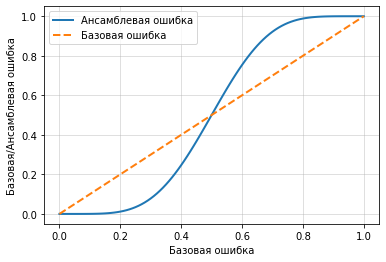

In [6]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
             for error in error_range]
plt.plot(error_range, ens_errors, label='Ансамблевая ошибка',
        linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Базовая ошибка',
        linewidth=2)
plt.xlabel('Базовая ошибка')
plt.ylabel('Базовая/Ансамблевая ошибка')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)


In [12]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])


In [14]:
p

array([0.58, 0.42])

In [15]:
np.argmax(p)

0

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ Ансамблевый классификатор с мажоритарным голосованием

    Параметры
    _________
    classifiers : подобен массиву, ОРМА = [n_classifiers]
        Различные классификаторы для ансамбля

    vote : str, {'classlabel', 'probability'} (По умолчанию='classlabel')
      Если 'classlabel' прогноз основывается на результате argmax меток. 
      В случае 'probability', для прогнозирования метки класса применяется 
      argmax суммы вероятностей.

    weights : подобен массиву, форма = [n_classifiers], Не обязательно (По умолчанию=None)
      Если предоставляется список значений `int` или `float`, тогда
      классификаторы назначают веса по важностс, в случае `weights=None` 
      используются равномерные веса.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Подгоняет классификаторы.

        Параметры
        _________
        X : {подобен массиву, разреженная матрица}, форма = [n_examples, n_features]
            Матрица обучающих образцов.

        y : подобен массиву, форма = [n_examples]
            Вектор целевых меток класса.

        Возвращает
        __________
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote должно быть 'probability' или 'classlabel'"
                             "; получено (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Количество классификаторов и количество весов'
                             '; получено %d весов, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Прогнозирует метки классов для X.

        Параметры
        _________
        X : {подобен массиву, разреженная матрица}, форма = [n_examples, n_features]
            Матрица обчающих образцов.

        Возвращает
        __________
        maj_vote : подобен массиву, форма = [n_examples]
            Спрогнозированные метки классов.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Прогнозируем вероятности классов для X.

        Параметры
        _________
        X : {подобен массиву, разреженная матрица}, форма = [n_examples, n_features]
            Обучающие вектор, где n_examples  - количество образцов, а 
            n_features - количество признаков

        Возвращает
        ----------
        avg_proba : подобен массиву, форма = [n_examples, n_classes]
            Взвешенная усредненная вероятность для каждого класса на образец
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Получает имена параметров классификатора для решетчатого поиска """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out